#### SIGNATE 【練習問題】ワインの品種の予測
#### https://signate.jp/competitions/112
#### その2
  
<その1からの引継ぎ>
* 重要度が低い項目は削除してもよさそう   
  'Nonflavanoid phenols','Proanthocyanins','Magnesium','Ash','Total phenols','Malic acid','Alcalinity of ash'
* ランダムフォレストのn_estimatorsはいくつか試していい感じのやつを採用する

* 重要度ランキング

| label | importrances | |
|-|-|-|
|Proline| 0.202150 |
|Color intensity|0.175354|
|Flavanoids|0.133476|
|Alcohol|0.084672|
|Hue|0.083769|
|OD280/OD315 of diluted wines|0.083648|
|Alcalinity of ash|0.051718|削除|
|Malic acid|0.050238|削除|
|Total phenols|0.049666|削除|
|Ash|0.031812|削除|
|Magnesium|0.019813|削除|
|Proanthocyanins|0.019026|削除|
|Nonflavanoid phenols|0.014656|削除|


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_train = pd.read_csv('train.tsv',delimiter='\t' )
# 特徴変数
X = df_train.iloc[:,2:]
# 目的変数
Y = df_train['Y']

# 重要度が低い項目を削除  ←項目を削除してもしなくても変わらなかったので削除やめる
# for l in ['Nonflavanoid phenols','Proanthocyanins','Magnesium','Ash','Total phenols','Malic acid','Alcalinity of ash']:
#     del X[l]

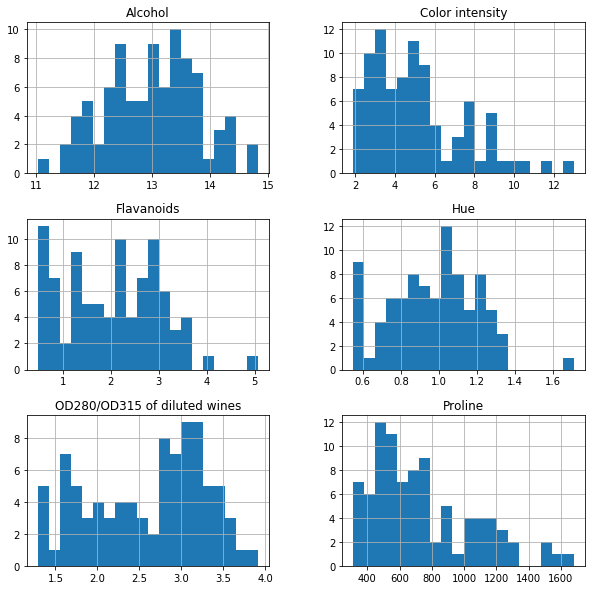

In [9]:
# 外れ値をヒストグラムで確認
from pylab import rcParams

# グラフが見きれないようにするためサイズを大きくしておく
rcParams['figure.figsize'] = 10, 10 
X.hist(bins=20)
plt.tight_layout
plt.show()

In [10]:
# 品種の種類を抽出
np_unique_y = np.unique(Y.values)
np_unique_y

array([1, 2, 3], dtype=int64)

In [11]:
# 品種単位にデータを分割　K:Y V:DataFrame
df_y_dict = {}
for y in np_unique_y:
    df_y_dict[y] = df_train.query('Y == ' + str(y))

In [62]:
# 外れ値の検出を試してみる
df_tmp = df_y_dict[2]
np_y_flavanoids =df_tmp['Flavanoids'].values
np_y_flavanoids

array([2.13, 2.5 , 1.76, 1.3 , 0.57, 2.  , 1.84, 1.28, 2.21, 2.11, 2.14,
       2.89, 1.6 , 1.79, 2.17, 2.17, 2.04, 2.27, 2.24, 1.36, 1.25, 1.09,
       1.59, 5.08, 2.01, 2.26, 1.94, 2.86, 2.09, 2.65, 2.92, 1.61, 3.03,
       1.57, 1.85, 1.75, 2.53])

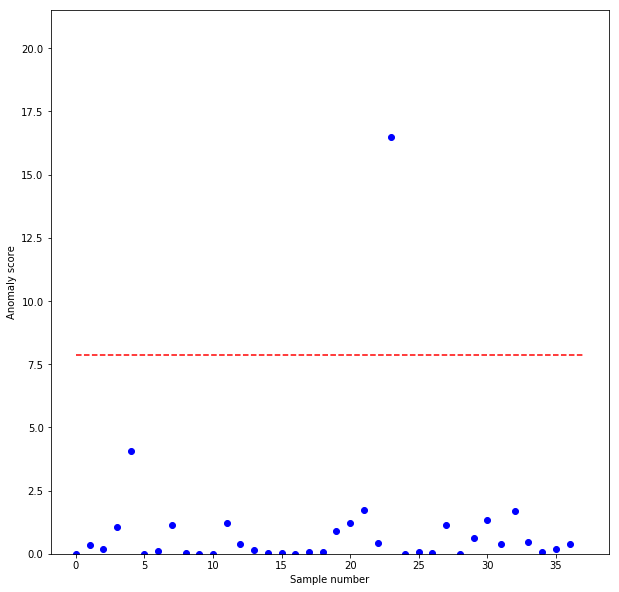

In [87]:
# ホテリング理論を使用して外れ値を検知する
from statistics import mean, variance
from scipy import stats
data = np_y_flavanoids
num = np.arange(0,data.size)

# 標本平均
mean = mean(data)

# 標本分散
variance = variance(data)

# 異常度
anomaly_scores = []
for x in data:
    anomaly_score = (x - mean)**2 / variance
    anomaly_scores.append(anomaly_score)

# カイ二乗分布による1%水準の閾値
threshold = stats.chi2.interval(0.99, 1)[1]

# 結果の描画
plt.plot(num, anomaly_scores, "o", color = "b")
plt.plot([0,num.size],[threshold, threshold], 'k-', color = "r", ls = "dashed")
plt.xlabel("Sample number")
plt.ylabel("Anomaly score")
plt.ylim([0,max(anomaly_scores)+5])
plt.show()

In [88]:
print("threshold=" + str(threshold))
for i in range(len(data)):
    is_over = " ←外れ値" if anomaly_scores[i] > threshold else ""
    print("[" + str(i) + "]data=" + str(data[i]) + ", anomaly_scores=" + str(anomaly_scores[i]) + " " + is_over)

threshold=7.879438576622417
[0]data=2.13, anomaly_scores=0.0073935020299739735 
[1]data=2.5, anomaly_scores=0.3419607524196319 
[2]data=1.76, anomaly_scores=0.17040644260548918 
[3]data=1.3, anomaly_scores=1.0669211317304286 
[4]data=0.57, anomaly_scores=4.068350423535168 
[5]data=2.0, anomaly_scores=0.007968165745281383 
[6]data=1.84, anomaly_scores=0.09299874898802195 
[7]data=1.28, anomaly_scores=1.1233462322556484 
[8]data=2.21, anomaly_scores=0.03757071456713881 
[9]data=2.11, anomaly_scores=0.0034838241036095267 
[10]data=2.14, anomaly_scores=0.00989353477434527 
[11]data=2.89, anomaly_scores=1.2332641748613145 
[12]data=1.6, anomaly_scores=0.3950066338326172 
[13]data=1.79, anomaly_scores=0.13865258859299393 
[14]data=2.17, anomaly_scores=0.01957440813221498 
[15]data=2.17, anomaly_scores=0.01957440813221498 
[16]data=2.04, anomaly_scores=0.0012490207663032517 
[17]data=2.27, anomaly_scores=0.07546904984330484 
[18]data=2.24, anomaly_scores=0.054884300861654925 
[19]data=1.36, a

品種単位で各要素について外れ値を検出し平均値で置換してみる

In [6]:
from statistics import mean, variance
from scipy import stats
# ホテリング理論の計算を関数化
def calc_anomaly_scores(data, alpha=0.99):
    print("=== calc_anomaly_scores ===")
    print(data)
    # 標本平均
    data_mean = mean(data)
    # 標本分散
    data_variance = variance(data)
    
    # 異常度
    anomaly_scores = []
    for x in data:
        anomaly_score = (x - data_mean)**2 / data_variance
        anomaly_scores.append(anomaly_score)

    # カイ二乗分布による閾値
    threshold_ = stats.chi2.interval(alpha, 1)[1]
    print("threshold={}, anomaly_scores={}".format(threshold_, anomaly_scores))
    return threshold_, anomaly_scores

In [7]:
def specify_anomaly_value(data, threshold, anomaly_scores):
    print("=== specify_anomaly_value ===")
    nomaly_data = []
    anomaly_data = []
    for i in range(len(data)):
        # 閾値以下のデータを抽出
        if anomaly_scores[i] <= threshold:
            nomaly_data.append(data[i])
            
        # 異常値を保存
        else:
            anomaly_data.append(data[i])
            
    # 閾値以下のデータの平均値
    # mean_ = mean(nomaly_data)
    # 単純な平均
    mean_ = mean(data)
    print("threshold={}, mean_={}, anomaly_data={}".format(threshold, mean_, anomaly_data))
    return mean_, anomaly_data

In [8]:
# df_:対象データフレーム y:品種Y　column:置換対象の要素　anomaly_data:異常値リスト nomaly_data_mean:置換する平均値
def replace_df_anomaly_data(df_, y, column, anomaly_data, nomaly_data_mean):
    print("=== replace_df_anomaly_data ===")
    # 引数の品種ならばTrue データの数分True,Falseが生成
    mask1 = df_['Y'] == y
    # 異常値リストに含まれていればTrue データの数分True,Falseが生成
    mask2 = df_[column].isin(anomaly_data)
    # 特定品種かつ異常値リストに含まれている場合のみTrue
    mask = np.logical_and(mask1, mask2)
    # where(条件, 条件がfalseの場合置換する, inplace:直接編集する)
    # 条件がfalseの場合置換するので、反転する
    df_[column].where(np.logical_not(mask), nomaly_data_mean, inplace=True)

In [30]:
import copy
df_train2 = copy.deepcopy(df_train)
for y in np_unique_y:
    df_tmp = df_y_dict[y]
    for column in X.columns.values:
        print("################################")
        print("### "+column+" ###")
        # 特定品種の特定要素を抽出
        np_y_item = df_tmp[column].values
        # 閾値と異常度を計算 alpha=0.99では0.97753 
        threshold_, anomaly_scores = calc_anomaly_scores(np_y_item, alpha=0.95)
        # 平均値と置換対象を計算
        nomaly_data_mean, anomaly_data = specify_anomaly_value(np_y_item, threshold_, anomaly_scores)
        
        print("Y={}, column={}, threshold={}, anomaly_data={}, mean={}".format(y, column,threshold_, anomaly_data, nomaly_data_mean))
        # 品種、要素が一致する中から異常値を平均値に置換する
        replace_df_anomaly_data(df_train2, y, column, anomaly_data, nomaly_data_mean)
        
   

################################
### Alcohol ###
=== calc_anomaly_scores ===
[13.05 13.05 13.05 13.07 13.74 13.83 13.64 14.23 13.94 13.83 13.28 13.56
 13.76 13.2  14.39 14.38 13.39 14.19 14.83 14.37 13.48 13.16 13.24 14.75
 13.05 13.58 13.29 14.22]
threshold=5.023886187314888, anomaly_scores=[1.4143282185146693, 1.4143282185146693, 1.4143282185146693, 1.3283992649773748, 0.00587717565838616, 0.05845877089791228, 0.011407018779141095, 0.9518890768424941, 0.1967769773053163, 0.05845877089791228, 0.5887226405859604, 0.06430117036897098, 0.012849586549772626, 0.8354979005486949, 1.6108540344670668, 1.5646197374183208, 0.31975587975167197, 0.814075769154807, 4.311629414643778, 1.5190586386625284, 0.16028001270833514, 0.9750422895611343, 0.7067246842236331, 3.723638791334287, 1.4143282185146693, 0.04703844271374502, 0.5609051254089458, 0.9164259524811316]
=== specify_anomaly_value ===
threshold=5.023886187314888, mean_=13.698214285714286, anomaly_data=[]
Y=1, column=Alcohol, threshold=5.0238

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
def hsit_show(df_):
	# 特徴変数
	X_ = df_.iloc[:,2:]
	# 目的変数
	Y_ = df_['Y']

	# 重要度が低い項目を削除
# 	for l in ['Nonflavanoid phenols','Proanthocyanins','Magnesium','Ash','Total phenols','Malic acid','Alcalinity of ash']:
# 	    del X_[l]

	# 外れ値をヒストグラムで確認
	# グラフが見きれないようにするためサイズを大きくしておく
	rcParams['figure.figsize'] = 10, 10 
	X_.hist(bins=20)
	plt.tight_layout
	plt.show()

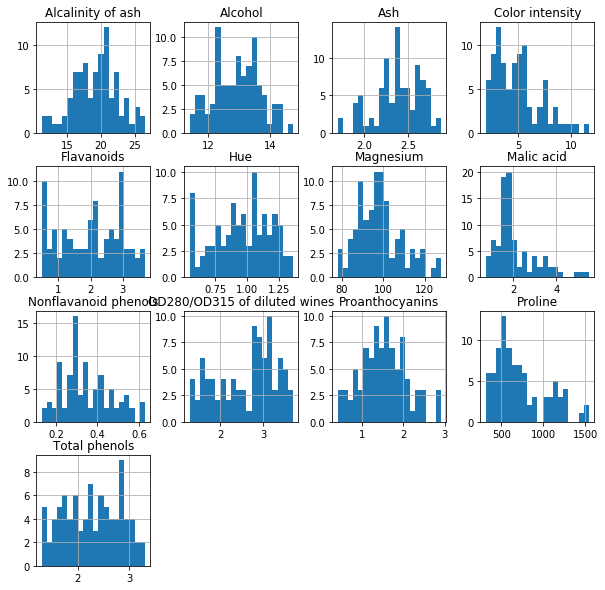

In [17]:
# 外れ値を処理できているか確認
hsit_show(df_train2)

In [20]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 一連の流れを関数化
def random_forest_classifier_fit_score(x, y, n_estimators=1000):
    # 学習用とテスト用に分割
    X_tr, X_ts, y_tr, y_ts = train_test_split(x, y, test_size = 0.5)
    # ランダムフォレスト作成
    clf_rf_func = RandomForestClassifier(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    # 学習
    clf_rf_func.fit(X=X_tr, y=y_tr)
    # 評価
    score = clf_rf_func.score(X=X_ts, y=y_ts)
#     print("RandomForestClassifier.score=" + str(score))
    
    # 重要度を確認
    imp = pd.DataFrame(x.columns, columns=['label'])
    imp['importrances'] = clf_rf_func.feature_importances_
    imp = imp.sort_values('importrances', ascending=False)
#     print(imp)
    
    return clf_rf_func, score, imp

In [48]:
def calc_random_forest_classifier(df_):
    # 特徴変数
    X_ = df_.iloc[:,2:]
    # 目的変数
    Y_ = df_['Y']

    # 重要度が低い項目を削除
#     for l in ['Nonflavanoid phenols','Proanthocyanins','Magnesium','Ash','Total phenols','Malic acid','Alcalinity of ash']:
#         del X_[l]
        
    n_estimators_list = []
    clf_list = []
    score_list = []
    imp_list = []
    count = 0
    # 100から10000までで100単位でn_estimatorsの値を増やしてテスト
    for n in range(100, 10000, 100):
        # 学習と評価
        clf, score, imp = random_forest_classifier_fit_score(X_, Y_, n_estimators=n)
        # 結果を保存
        n_estimators_list.append(n)
        clf_list.append(clf)
        score_list.append(score)
        imp_list.append(imp)
        print("[{}]n_estimators={}, score={}".format(count,n,score))
        count = count + 1
    
    return n_estimators_list, clf_list, score_list, imp_list

In [49]:
n_estimators_list, clf_list, score_list, imp_list = calc_random_forest_classifier(df_train2)

[0]n_estimators=100, score=0.9629629629629629
[1]n_estimators=200, score=0.9629629629629629
[2]n_estimators=300, score=1.0
[3]n_estimators=400, score=0.9259259259259259
[4]n_estimators=500, score=0.8888888888888888
[5]n_estimators=600, score=1.0
[6]n_estimators=700, score=1.0
[7]n_estimators=800, score=1.0
[8]n_estimators=900, score=1.0
[9]n_estimators=1000, score=0.9629629629629629
[10]n_estimators=1100, score=0.9629629629629629
[11]n_estimators=1200, score=0.9629629629629629
[12]n_estimators=1300, score=0.9629629629629629
[13]n_estimators=1400, score=0.9629629629629629
[14]n_estimators=1500, score=1.0
[15]n_estimators=1600, score=1.0
[16]n_estimators=1700, score=0.9629629629629629
[17]n_estimators=1800, score=1.0
[18]n_estimators=1900, score=0.9629629629629629
[19]n_estimators=2000, score=1.0
[20]n_estimators=2100, score=1.0
[21]n_estimators=2200, score=0.9629629629629629
[22]n_estimators=2300, score=1.0
[23]n_estimators=2400, score=0.9629629629629629
[24]n_estimators=2500, score=0.9

In [61]:
result_clf = clf_list[5]

# テスト
df_test = pd.read_csv('test.tsv',delimiter='\t' )
# 特徴変数
test_X = df_test.iloc[:,1:]
# for l in ['Nonflavanoid phenols','Proanthocyanins','Magnesium','Ash','Total phenols','Malic acid','Alcalinity of ash']:
#     del test_X[l]

ans = result_clf.predict(X=test_X)
ans

array([1, 3, 2, 2, 1, 1, 2, 2, 1, 2, 1, 3, 1, 2, 3, 1, 3, 1, 3, 2, 3, 2,
       2, 2, 2, 2, 3, 3, 2, 3, 1, 3, 3, 1, 1, 2, 3, 2, 3, 2, 3, 3, 2, 1,
       3, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 3, 3, 3, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 3, 2, 3, 1, 1, 2, 3, 1, 1, 2, 2, 3, 1, 1, 1, 2, 1, 3, 3, 2,
       2], dtype=int64)

In [62]:
result_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [63]:
# result6の結果 0.98876
ans_old=np.array([1, 3, 2, 2, 1, 1, 2, 2, 1, 2, 1, 3, 1, 2, 3, 1, 3, 2, 3, 2, 3, 2,
       2, 2, 2, 2, 3, 3, 2, 3, 1, 3, 3, 1, 1, 2, 3, 2, 3, 2, 3, 3, 2, 1,
       3, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 3, 3, 3, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 3, 2, 3, 1, 1, 2, 3, 1, 1, 2, 2, 3, 1, 1, 1, 2, 1, 2, 3, 2,
       2])

In [64]:
import collections
diff_list = []
for i in range(len(ans)):
    diff_list.append(int(ans[i])-int(ans_old[i]))
collections.Counter(diff_list)

Counter({0: 87, -1: 1, 1: 1})

In [65]:
# 提出用に加工
np_id = df_test['id'].values
dd=pd.DataFrame({"id":np_id, "ans":ans})
dd.to_csv("result08.csv",header=False,index=False)


In [67]:
for i in range(len(clf_list)):
    clf_tmp = clf_list[i]
    ans_tmp = clf_tmp.predict(X=test_X)
    
    diff_list = []
    for j in range(len(ans_tmp)):
        if (ans_tmp[j] != ans_old[j]):
            diff_list.append(j)
    
    
    print("clf_{} score={}, diff:{}".format(i, score_list[i], diff_list))

clf_0 score=0.9629629629629629, diff:[17, 71]
clf_1 score=0.9629629629629629, diff:[17, 85]
clf_2 score=1.0, diff:[17, 85]
clf_3 score=0.9259259259259259, diff:[34, 71]
clf_4 score=0.8888888888888888, diff:[33, 34, 68]
clf_5 score=1.0, diff:[17, 85]
clf_6 score=1.0, diff:[17]
clf_7 score=1.0, diff:[17]
clf_8 score=1.0, diff:[17]
clf_9 score=0.9629629629629629, diff:[34, 71, 80, 85]
clf_10 score=0.9629629629629629, diff:[17]
clf_11 score=0.9629629629629629, diff:[]
clf_12 score=0.9629629629629629, diff:[33, 34]
clf_13 score=0.9629629629629629, diff:[17, 71, 85]
clf_14 score=1.0, diff:[17]
clf_15 score=1.0, diff:[17, 85]
clf_16 score=0.9629629629629629, diff:[17]
clf_17 score=1.0, diff:[17, 71]
clf_18 score=0.9629629629629629, diff:[17, 47, 85]
clf_19 score=1.0, diff:[17]
clf_20 score=1.0, diff:[17]
clf_21 score=0.9629629629629629, diff:[33]
clf_22 score=1.0, diff:[17, 85]
clf_23 score=0.9629629629629629, diff:[17]
clf_24 score=0.9629629629629629, diff:[17, 33, 71]
clf_25 score=0.9259259